# IMPORTS

In [1]:
from google.colab import drive, files # google colab specific
import requests
import pandas as pd
import os
import warnings
import sys
import matplotlib.pyplot as plt

In [2]:
sys.setrecursionlimit(10000000)

# MY API KEY, USE YOUR OWN!!

In [3]:
estated_api_key = 'PJtwOr0OgXggh4jy8treXK4MgKHZna'

# The entries Estated needs, so we can search
## Credit: https://www.youtube.com/watch?v=HxdGS48cdSU&t=506s&ab_channel=AnalyticsAriel





In [4]:
def get_estated_detail(api_key, 
                       street_address, 
                       city, 
                       state, 
                       zip_code):
  # sample API get request
  base_url = 'https://apis.estated.com/v4/property'

  params = (
      ('token', estated_api_key),
      ('street_address', street_address),
      ('city', city),
      ('state', state),
      ('zip_code', zip_code),
  )

  response = requests.get(base_url, params=params)
  return response

#Estated throttles the amount of searches so only one address can be entered

In [5]:
# create a dataframe
d = {'address': ['9307 crandon lane, tampa, FL 33635']}
_df_addresses = pd.DataFrame(data=d)
_df_addresses

,address
0,"9307 crandon lane, tampa, FL 33635"


# We split address into elements, so we can feed into API, also credit to analysticsariel

In [6]:
# split dataframe into sub address elements
df_addresses = _df_addresses.copy()
df_addresses['street'] = df_addresses.apply(lambda x: x['address'].split(',')[0], axis=1)
df_addresses['city'] = df_addresses.apply(lambda x: x['address'].split(',')[1].strip(), axis=1)
df_addresses['state'] = df_addresses.apply(lambda x: x['address'].split(',')[2].split()[0], axis=1)
df_addresses['zip_code'] = df_addresses.apply(lambda x: x['address'].split(',')[2].split()[1], axis=1)
df_addresses

,address,street,city,state,zip_code
0,"9307 crandon lane, tampa, FL 33635",9307 crandon lane,tampa,FL,33635


# The for loop was supposed to iterrate but just irrates through one address and calls the function get_estated_detail

In [7]:
# get estated property detail per address

response_list = []
# iterate through rows in the dataframe (table)
for index, row in df_addresses.iterrows():
  # get parameters
  address = row['address']
  street = row['street']
  city = row['city']
  state = row['state']
  zip_code = row['zip_code']
  # get api response
  print('Getting data for address: {0}'.format(address))
  response = get_estated_detail(estated_api_key, 
                        street, 
                        city, 
                        state, 
                        zip_code)
  # append to list
  response_list.append(response)

Getting data for address: 9307 crandon lane, tampa, FL 33635


In [8]:
import json

In [9]:
response.json()

{'data': {'address': {'carrier_code': 'C058',
   'census_tract': '120570116.073012',
   'city': 'TAMPA',
   'formatted_street_address': '9307 CRANDON LN',
   'geocoding_accuracy': 'PARCEL CENTROID',
   'latitude': 28.033488,
   'longitude': -82.585887,
   'state': 'FL',
   'street_name': 'CRANDON',
   'street_number': '9307',
   'street_post_direction': None,
   'street_pre_direction': None,
   'street_suffix': 'LN',
   'unit_number': None,
   'unit_type': None,
   'zip_code': '33635',
   'zip_plus_four_code': '1096'},
  'assessments': [{'improvement_value': 170584,
    'land_value': 40817,
    'total_value': 211401,
    'year': 2021},
   {'improvement_value': None,
    'land_value': None,
    'total_value': 148951,
    'year': 2020},
   {'improvement_value': None,
    'land_value': None,
    'total_value': 135381,
    'year': 2019},
   {'improvement_value': None,
    'land_value': None,
    'total_value': 135178,
    'year': 2018}],
  'boundary': {'geojson': {'coordinates': [[[[-82.58

# Allows us to flatten the json and extract list then storing the data into a dataframe

In [10]:
d = response.json()

In [11]:
df5 = pd.json_normalize(d['data']['deeds'])

In [12]:
df5 = df5.drop(['document_type','buyer_unit_number','buyer_unit_type','buyer_city','buyer_address','buyer2_last_name','buyer2_first_name','buyer_last_name','buyer_first_name','seller_zip_plus_four_code','seller_zip_code','seller_state','seller_city','seller_unit_number','seller_address','seller2_last_name','seller2_first_name','seller_last_name','seller_first_name','real_estate_owned','original_contract_date','deed_book','deed_page','document_id','sale_price_description','transfer_tax','distressed_sale','buyer_state','buyer_zip_code','buyer_zip_plus_four_code','lender_name','lender_type','loan_amount','loan_type','loan_due_date','loan_finance_type','loan_interest_rate'], axis = 1)

In [13]:
df5 = df5.rename(columns={"recording_date": "Recording Date", "sale_price": "Sale Price"})

In [14]:
#turn recording date to time seriespd.to_datetime(df5['Recording Date']
df5.head()

,Recording Date,Sale Price
0,2020-05-21,240000
1,1995-06-05,89500


In [15]:
d = response.json()
df5 = pd.json_normalize(d['data']['deeds'])
df5 = df5.drop(['document_type','buyer_unit_number','buyer_unit_type','buyer_city','buyer_address','buyer2_last_name','buyer2_first_name','buyer_last_name','buyer_first_name','seller_zip_plus_four_code','seller_zip_code','seller_state','seller_city','seller_unit_number','seller_address','seller2_last_name','seller2_first_name','seller_last_name','seller_first_name','real_estate_owned','original_contract_date','deed_book','deed_page','document_id','sale_price_description','transfer_tax','distressed_sale','buyer_state','buyer_zip_code','buyer_zip_plus_four_code','lender_name','lender_type','loan_amount','loan_type','loan_due_date','loan_finance_type','loan_interest_rate'], axis = 1)
df5 = df5.rename(columns={"recording_date": "Recording Date", "sale_price": "Sale Price"})

In [16]:
df5['Recording Date'][0] = '2020-05-31'
df5['Recording Date'][1] = '1995-06-30'
df5['Recording Date'] = pd.to_datetime(df5['Recording Date'])
df5 = df5.set_index('Recording Date').resample('1M').interpolate()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


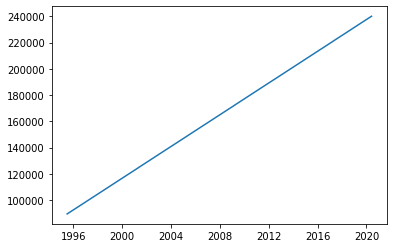

In [17]:
print(plt.plot(df5))

In [18]:
pd.json_normalize(d['data']['assessments'])

,year,land_value,improvement_value,total_value
0,2021,40817.0,170584.0,211401
1,2020,NaN,NaN,148951
2,2019,NaN,NaN,135381
3,2018,NaN,NaN,135178


In [19]:
df1 = pd.json_normalize(d['data']['assessments'])

In [20]:
df1 = df1.rename(columns={"year": "Tax year", "land_value": "Land value", "improvement_value": "Improvement value","total_value":"Total tax value"})

In [21]:
pd.json_normalize(d['data']['address'])

,street_number,street_pre_direction,street_name,street_suffix,street_post_direction,unit_type,unit_number,formatted_street_address,city,state,zip_code,zip_plus_four_code,carrier_code,latitude,longitude,geocoding_accuracy,census_tract
0,9307,None,CRANDON,LN,None,None,None,9307 CRANDON LN,TAMPA,FL,33635,1096,C058,28.033488,-82.585887,PARCEL CENTROID,120570116.073012


In [22]:
df2 = pd.json_normalize(d['data']['address'])

In [23]:
df2 = df2.drop(['street_number','street_post_direction','street_pre_direction','street_name','street_suffix','carrier_code','latitude','longitude','geocoding_accuracy','census_tract'], axis = 1)

In [24]:
df2 = df2.rename(columns={"unit_type": "Unit Type", "unit_number": "Unit Number", "formatted_street_address": "Street Address","city": "City","state": "State","zip_code": "Zip Code","zip_plus_four_code": "Zip Plus Four Code"})

In [25]:
pd.json_normalize(d['data']['valuation'])

,value,high,low,forecast_standard_deviation,date
0,344000,374960,313040,9,2022-02-02


In [26]:
df3 = pd.json_normalize(d['data']['valuation'])

In [27]:
df3 = df3.rename(columns={"value": "Estated current property value", "high": "Estated highest probable value", "low": "Estated lowest probable value","forecast_standard_deviation": "Forecast standard deviation","date": "Date"})

In [28]:
pd.json_normalize(d['data']['structure'])

,year_built,effective_year_built,stories,rooms_count,beds_count,baths,partial_baths_count,units_count,parking_type,parking_spaces_count,...,plumbing_fixtures_count,interior_wall_type,water_type,sewer_type,total_area_sq_ft,other_areas,other_rooms,other_features,other_improvements,amenities
0,1995,2007,1,None,3,2.0,None,1,GARAGE,2,...,None,GYPSUM BOARD,None,None,1510,"[{'type': 'BASE AREA', 'sq_ft': '1510'}, {'typ...",[],[],[],[]


In [29]:
df4 = pd.json_normalize(d['data']['structure'])

In [30]:
df4 = df4.drop(['plumbing_fixtures_count','interior_wall_type','water_type','sewer_type','other_areas','other_rooms','other_features','other_improvements','amenities','basement_type','fireplaces','air_conditioning_type','heating_fuel_type','heating_type','roof_style_type','roof_material_type','foundation_type','exterior_wall_type','pool_type'], axis = 1)

In [31]:
df4 = df4.rename(columns={"year_built": "Year built", "effective_year_built": "Effective year built", "stories": "Stories","rooms_count": "Rooms count","beds_count": "Beds","baths": "Baths","partial_baths_count": "Partial baths","units_count": "Units count","parking_type": "Parking type","parking_spaces_count": "Parking spaces","architecture_type": "Architecture type","construction_type": "Construction type", "quality": "Quality", "condition": "Condition", "flooring_types": "Flooring types","total_area_sq_ft": "Total area sq ft."})

# Concat on the dataframes. then axis = 1 is how I got it into the first row all together

In [32]:
pdList = [df2, df3, df4, df1, df5]  # List of your dataframes
new_df = pd.concat(pdList, axis = 1)

In [33]:
new_df

,Unit Type,Unit Number,Street Address,City,State,Zip Code,Zip Plus Four Code,Estated current property value,Estated highest probable value,Estated lowest probable value,...,Construction type,Quality,Condition,Flooring types,Total area sq ft.,Tax year,Land value,Improvement value,Total tax value,Sale Price
0,None,None,9307 CRANDON LN,TAMPA,FL,33635,1096,344000.0,374960.0,313040.0,...,MASONRY,C,AVERAGE,[CARPET],1510.0,2021.0,40817.0,170584.0,211401.0,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2020.0,NaN,NaN,148951.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2019.0,NaN,NaN,135381.0,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2018.0,NaN,NaN,135178.0,NaN
1995-06-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89500.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,237986.622074
2020-02-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,238489.966555
2020-03-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,238993.311037
2020-04-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,239496.655518


In [34]:
# download

new_df.to_csv('estated_output.csv', index=False)
files.download('estated_output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>